In [1]:
import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats
from IPython.display import Image

# I. Data preprocessing

In [78]:
with open("OF_res.pkl","rb") as f:
    OF = pickle.load(f)
    
with open("GPOMS_res.pkl","rb") as f:
    GPOMS = pickle.load(f)
    
DJIA = pd.read_csv("DJIA_price.csv")

In [6]:
# 你可能需要這行？
# OF = pd.read_pickle("OF_res.pkl")
# GPOMS = pd.read_pickle("GPOMS_res.pkl")
# DJIA = pd.read_csv("DJIA_price.csv")

ValueError: unsupported pickle protocol: 5

In [79]:
OF = OF.drop(["tweets_processed", "tweet_size"], axis=1)
OF.head()

,positive_point,negative_point,ratio,norm_ratio
date_processed,,,,
2022-05-01,34.5,1.0,34.500000,4.081169
2022-05-02,72.0,15.0,4.800000,-0.462093
2022-05-03,86.0,17.5,4.914286,-0.444611
2022-05-04,100.0,15.0,6.666667,-0.176546
2022-05-05,79.0,15.0,5.266667,-0.390707


In [80]:
DJIA = DJIA.drop(["High", "Low", "Open", "Volume", 'Adj Close'], axis=1)
DJIA.head() # TODO1: filled in the missing value

,Date,Close
0,2022-04-14,34451.230469
1,2022-04-18,34411.691406
2,2022-04-19,34911.199219
3,2022-04-20,35160.789062
4,2022-04-21,34792.761719


In [81]:
GPOMS = GPOMS.drop(["tweets_processed", "tweet_size", "GPOMS_preprocess_data", "sum_index", "avg_index"], axis=1)
GPOMS.head()

,GPOMS_sum,GPOMS_avg
date_processed,,
2022-05-01,"[0.455, 0.5309999999999998, -0.008, 2.529, 0.5...","[0.11375, 0.13274999999999995, -0.002, 0.4215,..."
2022-05-02,"[0.29500000000000004, 2.207, -1.18399999999999...","[0.036875000000000005, 0.16976923076923076, -0..."
2022-05-03,"[0.102, 0.7470000000000002, -1.802000000000000...","[0.020399999999999998, 0.09337500000000003, -0..."
2022-05-04,"[2.695, 2.8609999999999998, -2.491, 10.7340000...","[0.19249999999999998, 0.16829411764705882, -0...."
2022-05-05,"[-1.8730000000000002, 1.2449999999999999, -1.4...","[-0.18730000000000002, 0.1383333333333333, -0...."


In [82]:
GPOMS_prim = GPOMS.copy()
GPOMS_prim[['Calm','Kind','Happy','Alert','Sure','Vital']] = pd.DataFrame(GPOMS.GPOMS_avg.tolist(), index= GPOMS.index)
GPOMS_prim = GPOMS_prim.drop(['GPOMS_sum', 'GPOMS_avg'], axis=1)
GPOMS_prim

,Calm,Kind,Happy,Alert,Sure,Vital
date_processed,,,,,,
2022-05-01,0.113750,0.132750,-0.002000,0.421500,0.104200,-0.211500
2022-05-02,0.036875,0.169769,-0.098667,0.329500,0.102600,-0.021833
2022-05-03,0.020400,0.093375,-0.163818,0.557714,0.141286,0.215077
2022-05-04,0.192500,0.168294,-0.166067,0.447250,0.101750,0.180778
2022-05-05,-0.187300,0.138333,-0.159667,0.312538,0.173375,0.140182
...,...,...,...,...,...,...
2022-06-26,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
2022-06-27,0.227000,0.113250,-0.049333,0.580214,0.192500,0.191100
2022-06-28,0.010100,0.158545,-0.128545,0.377867,0.196909,0.092214


In [83]:
# 標準化？
GPOMS_norm = GPOMS_prim.copy()
GPOMS_norm = (GPOMS_prim-GPOMS_prim.mean()) / GPOMS_prim.std()
GPOMS_norm

,Calm,Kind,Happy,Alert,Sure,Vital
date_processed,,,,,,
2022-05-01,0.151191,0.163910,0.529308,-0.097583,-0.072328,-2.285624
2022-05-02,-0.213440,0.446157,-0.018814,-0.757931,-0.091876,-1.028685
2022-05-03,-0.291583,-0.136298,-0.388238,0.880121,0.380767,0.541341
2022-05-04,0.524714,0.434911,-0.400988,0.087242,-0.102261,0.314038
2022-05-05,-1.276737,0.206479,-0.364698,-0.879676,0.772818,0.045004
...,...,...,...,...,...,...
2022-06-26,-0.388343,-0.848221,0.540649,4.054713,-1.345393,-0.883994
2022-06-27,0.688353,0.015236,0.260917,1.041619,1.006478,0.382444
2022-06-28,-0.340438,0.360584,-0.188234,-0.410770,1.060346,-0.272881


# II. Regression on Opinion Finder and GPOMS

In [84]:
OF_norm = list(OF['norm_ratio'])
OF = list(OF['ratio'])
GPOMS_list = ['Calm', 'Kind', 'Happy', 'Alert', 'Sure', 'Vital']

GPOMS_data = {}
for d in GPOMS_list:
    GPOMS_data[d+"_norm"] = list(GPOMS_norm[d])

In [85]:
for col in GPOMS_norm:
    print(col) 

Calm
Kind
Happy
Alert
Sure
Vital


In [139]:
corr_df = pd.DataFrame(columns=['coeff', 'p'])

print("-----The result of [norm]-----\n")
for col in GPOMS_norm:
    # print(col)        
    r, p = stats.pearsonr(OF_norm, GPOMS_norm[col])
    corr_df.loc[col] = [r, p]
print(corr_df)

-----The result of [norm]-----

          coeff         p
Calm   0.153765  0.236749
Kind  -0.067411  0.605718
Happy  0.201815  0.118827
Alert  0.029667  0.820451
Sure  -0.109393  0.401339
Vital -0.221499  0.086243


In [138]:
#???
corr_df2 = pd.DataFrame(columns=['coeff', 'p'])

print("-----The result of [col]-----\n")
for col in GPOMS_prim:
    # print(col)        
    r, p = stats.pearsonr(OF, GPOMS_prim[col])
    corr_df2.loc[col] = [r, p]
print(corr_df2)

-----The result of [col]-----

          coeff         p
Calm   0.153765  0.236749
Kind  -0.067411  0.605718
Happy  0.201815  0.118827
Alert  0.029667  0.820451
Sure  -0.109393  0.401339
Vital -0.221499  0.086243


# III. Filled the missing value of DIJA by means (rolling based)

In [121]:
DJIA_dict = {}
for i, j in zip(DJIA['Date'], DJIA['Close']): 
    date_obj = datetime.datetime.strptime(i, '%Y-%m-%d')
    DJIA_dict[date_obj] = j

In [122]:
DJIA_dict_filled = DJIA_dict
start_date = datetime.date(2022, 4, 20)
end_date = datetime.date(2022, 7, 1)

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + datetime.timedelta(n)

for single_date in daterange(start_date, end_date):
    query_date = single_date.strftime("%Y-%m-%d")
    query_date = datetime.datetime.strptime(query_date, '%Y-%m-%d')
    if query_date not in DJIA_dict_filled.keys(): # missing value
        i = -1
        before = query_date + datetime.timedelta(-1)
        while before not in DJIA_dict_filled.keys(): 
            before += datetime.timedelta(-1)
        i = 1
        after = query_date + datetime.timedelta(1)
        while after not in DJIA_dict_filled.keys(): 
            after += datetime.timedelta(1)
        before_val = DJIA_dict_filled[before]
        after_val = DJIA_dict_filled[after]
        mean_val = (before_val+after_val)/2
        DJIA_dict_filled[query_date] = mean_val
        print('before: ', before)
        print('missing: ', query_date)
        print('after: ', after)
        print('-'*10)

before:  2022-04-22 00:00:00
missing:  2022-04-23 00:00:00
after:  2022-04-25 00:00:00
----------
before:  2022-04-23 00:00:00
missing:  2022-04-24 00:00:00
after:  2022-04-25 00:00:00
----------
before:  2022-04-29 00:00:00
missing:  2022-04-30 00:00:00
after:  2022-05-02 00:00:00
----------
before:  2022-04-30 00:00:00
missing:  2022-05-01 00:00:00
after:  2022-05-02 00:00:00
----------
before:  2022-05-06 00:00:00
missing:  2022-05-07 00:00:00
after:  2022-05-09 00:00:00
----------
before:  2022-05-07 00:00:00
missing:  2022-05-08 00:00:00
after:  2022-05-09 00:00:00
----------
before:  2022-05-13 00:00:00
missing:  2022-05-14 00:00:00
after:  2022-05-16 00:00:00
----------
before:  2022-05-14 00:00:00
missing:  2022-05-15 00:00:00
after:  2022-05-16 00:00:00
----------
before:  2022-05-20 00:00:00
missing:  2022-05-21 00:00:00
after:  2022-05-23 00:00:00
----------
before:  2022-05-21 00:00:00
missing:  2022-05-22 00:00:00
after:  2022-05-23 00:00:00
----------
before:  2022-05-27 

In [161]:
dates = list(DJIA_dict_filled.keys())
close = list(DJIA_dict_filled.values())

DJIA_df_filled = pd.DataFrame()
DJIA_df_filled['Dates'] = dates
DJIA_df_filled['Close'] = close
DJIA_df_filled = DJIA_df_filled.query(' "2022-04-20" <= Dates < "2022-7-05"').reset_index(drop=True)
DJIA_df_filled = DJIA_df_filled.sort_values(by='Dates').reset_index(drop=True)
DJIA_df_filled.head(15)

,Dates,Close
0,2022-04-20,35160.789062
1,2022-04-21,34792.761719
2,2022-04-22,33811.398438
3,2022-04-23,33930.429688
4,2022-04-24,33989.945312
5,2022-04-25,34049.460938
6,2022-04-26,33240.179688
7,2022-04-27,33301.929688
8,2022-04-28,33916.390625
9,2022-04-29,32977.210938


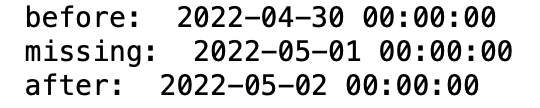

In [132]:
Image("picture_.png")

In [125]:
(33019.355469+33061.500000)/2

33040.4277345

In [116]:
# DJIA_df_filled.to_pickle('DJIA_filled_missing_val.pkl')

# IV. Granger Causality

Granger Causality test is used to determine **whether or not one time series is useful for forecasting another.**

This test uses the following null and alternative hypotheses:

> **Null Hypothesis (H0): Time series x does not Granger-cause time series y**

> **Alternative Hypothesis (HA): Time series x Granger-causes time series y**


If the p-value is less than a certain significance level (i.e. α = .05), then we can reject the null hypothesis and conclude that we have sufficient evidence to say that time series x Granger-causes time series y.

In [200]:
DJIA_df_filled = pd.DataFrame()
DJIA_df_filled['Dates'] = dates
DJIA_df_filled['Close'] = close
DJIA_df_filled = DJIA_df_filled.query(' "2022-04-20" <= Dates < "2022-7-01"').reset_index(drop=True)
DJIA_df_filled = DJIA_df_filled.sort_values(by='Dates').reset_index(drop=True)
DJIA_df_filled.tail()

,Dates,Close
67,2022-06-26,31453.864746
68,2022-06-27,31438.259766
69,2022-06-28,30946.990234
70,2022-06-29,31029.310547
71,2022-06-30,30775.429688


In [201]:
combine_df = DJIA_df_filled.copy()
combine_df = DJIA_df_filled.query(' "2022-05-01" <= Dates < "2022-7-01"').reset_index(drop=True)
combine_df['OF_val'] = OF_norm
combine_df.tail()

,Dates,Close,OF_val
56,2022-06-26,31453.864746,-1.073981
57,2022-06-27,31438.259766,-0.015416
58,2022-06-28,30946.990234,0.975841
59,2022-06-29,31029.310547,0.149794
60,2022-06-30,30775.429688,-0.250992


In [202]:
DJIA_df_new = pd.DataFrame()
DJIA_df_new['Dates'] = dates
DJIA_df_new['Close'] = close
DJIA_df_new = DJIA_df_new.query(' "2022-04-30" <= Dates < "2022-7-01"').reset_index(drop=True)
DJIA_df_new = DJIA_df_new.sort_values(by='Dates').reset_index(drop=True)
DJIA_df_new.head()

,Dates,Close
0,2022-04-30,33019.355469
1,2022-05-01,33040.427734
2,2022-05-02,33061.500000
3,2022-05-03,33128.789062
4,2022-05-04,34061.058594


In [203]:
DJIA_df_new['yesterday'] = DJIA_df_new['Close'].shift(1) #昨天？
DJIA_df_new['tomorrow'] = DJIA_df_new['Close'].shift(-1) #明天？

DJIA_df_new['next'] = DJIA_df_new['tomorrow'] #我們要評估的

DJIA_df_new.head(3)

,Dates,Close,yesterday,tomorrow,next
0,2022-04-30,33019.355469,NaN,33040.427734,33040.427734
1,2022-05-01,33040.427734,33019.355469,33061.500000,33061.500000
2,2022-05-02,33061.500000,33040.427734,33128.789062,33128.789062


In [204]:
DJIA_df_new['delta'] = DJIA_df_new['next']-DJIA_df_new['Close'] #
DJIA_df_new.head(3)

,Dates,Close,yesterday,tomorrow,next,delta
0,2022-04-30,33019.355469,NaN,33040.427734,33040.427734,21.072266
1,2022-05-01,33040.427734,33019.355469,33061.500000,33061.500000,21.072266
2,2022-05-02,33061.500000,33040.427734,33128.789062,33128.789062,67.289062


In [205]:
DJIA_df_new.drop(DJIA_df_new.tail(1).index, inplace=True)
DJIA_df_new = DJIA_df_new.drop(0).reset_index(drop=True)

In [206]:
DJIA_df_new

,Dates,Close,yesterday,tomorrow,next,delta
0,2022-05-01,33040.427734,33019.355469,33061.500000,33061.500000,21.072266
1,2022-05-02,33061.500000,33040.427734,33128.789062,33128.789062,67.289062
2,2022-05-03,33128.789062,33061.500000,34061.058594,34061.058594,932.269531
3,2022-05-04,34061.058594,33128.789062,32997.968750,32997.968750,-1063.089844
4,2022-05-05,32997.968750,34061.058594,32899.371094,32899.371094,-98.597656
5,2022-05-06,32899.371094,32997.968750,32572.535156,32572.535156,-326.835938
6,2022-05-07,32572.535156,32899.371094,32409.117188,32409.117188,-163.417969
7,2022-05-08,32409.117188,32572.535156,32245.699219,32245.699219,-163.417969
8,2022-05-09,32245.699219,32409.117188,32160.740234,32160.740234,-84.958984
9,2022-05-10,32160.740234,32245.699219,31834.109375,31834.109375,-326.630859


In [207]:
DJIA_df_new = DJIA_df_new.drop(columns=['Close', 'next'])
DJIA_df_new.head()

,Dates,yesterday,tomorrow,delta
0,2022-05-01,33019.355469,33061.500000,21.072266
1,2022-05-02,33040.427734,33128.789062,67.289062
2,2022-05-03,33061.500000,34061.058594,932.269531
3,2022-05-04,33128.789062,32997.968750,-1063.089844
4,2022-05-05,34061.058594,32899.371094,-98.597656


In [108]:
# DJIA_df_new['next'] = DJIA_df_new['Close'].shift(1)
# DJIA_df_new = DJIA_df_new.drop(0).reset_index(drop=True)
# DJIA_df_new['delta'] = DJIA_df_new['next']-DJIA_df_new['Close']
# DJIA_df_new = DJIA_df_new.drop(columns=['Close', 'next'])
# DJIA_df_new.head()

,Dates,delta
0,2022-05-01,-21.072266
1,2022-05-02,-21.072266
2,2022-05-03,-67.289062
3,2022-05-04,-932.269531
4,2022-05-05,1063.089844


In [209]:
combine_df2 = DJIA_df_new.copy()
OF_norm_2 = OF_norm[:-1]
combine_df2['OF_val'] = OF_norm_2
combine_df2.head()

,Dates,yesterday,tomorrow,delta,OF_val
0,2022-05-01,33019.355469,33061.500000,21.072266,4.081169
1,2022-05-02,33040.427734,33128.789062,67.289062,-0.462093
2,2022-05-03,33061.500000,34061.058594,932.269531,-0.444611
3,2022-05-04,33128.789062,32997.968750,-1063.089844,-0.176546
4,2022-05-05,34061.058594,32899.371094,-98.597656,-0.390707


In [210]:
#perform Granger-Causality test on DJIA index directly! (alpha=0.05)
from statsmodels.tsa.stattools import grangercausalitytests

# 1. Test if it have the predictive power on DJIA
# maxlag indicates the number of lags to use in the first time series
print("On the index directly:")
res1 = grangercausalitytests(combine_df[['Close', 'OF_val']], maxlag=[3]) 

print('-'*10)
print("On the index Change: ")
# 2. Test if it have the predictive power on the change(delta) of DJIA
res2 = grangercausalitytests(combine_df2[['delta', 'OF_val']], maxlag=[3]) 

On the index directly:

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6041  , p=0.1999  , df_denom=51, df_num=3
ssr based chi2 test:   chi2=5.4727  , p=0.1403  , df=3
likelihood ratio test: chi2=5.2297  , p=0.1557  , df=3
parameter F test:         F=1.6041  , p=0.1999  , df_denom=51, df_num=3
----------
On the index Change: 

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7535  , p=0.0522  , df_denom=50, df_num=3
ssr based chi2 test:   chi2=9.4169  , p=0.0242  , df=3
likelihood ratio test: chi2=8.7153  , p=0.0333  , df=3
parameter F test:         F=2.7535  , p=0.0522  , df_denom=50, df_num=3


In [211]:
grangercausalitytests(combine_df2[['OF_val', 'delta']], maxlag=[3]) # ???


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1741  , p=0.9134  , df_denom=50, df_num=3
ssr based chi2 test:   chi2=0.5954  , p=0.8975  , df=3
likelihood ratio test: chi2=0.5924  , p=0.8982  , df=3
parameter F test:         F=0.1741  , p=0.9134  , df_denom=50, df_num=3


{3: ({'ssr_ftest': (0.17410723711756568, 0.9134187827961311, 50.0, 3),
   'ssr_chi2test': (0.5954467509420747, 0.897473940141261, 3),
   'lrtest': (0.5923580949549319, 0.8981795630250556, 3),
   'params_ftest': (0.1741072371175814, 0.9134187827961198, 50.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])])}

[Review]

F test-> 越大 通過檢測的可能性越高？

chi-sqaure test:?

likelihood ratio test:?